# DeepWalk
The aim of this tutorial is constructing a graph of Wikipedia articles and extract node embeddings from it using DeepWalk algorithm.
DeepWalk embeddings are used to solve multiple graph-related problems such as: 
- link prediction, 
- node classification, 
- question-answering system 

and many more.

In [2]:
import random

import networkx as nx
from tqdm import tqdm
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset
Every row is a pair of graph nodes. The nodes of the resultant graph are the Wikipedia space themed pages. 
If a page has a hyperlink on another page, then there would be a link between the two pages in the graph.

In [3]:
df = pd.read_csv("space_data.tsv", sep = "\t")
df.head()

,source,target,depth
0,space exploration,discovery and exploration of the solar system,1
1,space exploration,in-space propulsion technologies,1
2,space exploration,robotic spacecraft,1
3,space exploration,timeline of planetary exploration,1
4,space exploration,landings on other planets,1


## Graph

Construct undirected graph and visualize part of it as a subgraph.

In [4]:
G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.Graph())

In [5]:
print(f'Total no. of nodes: {len(G)}')

Total no. of nodes: 2088


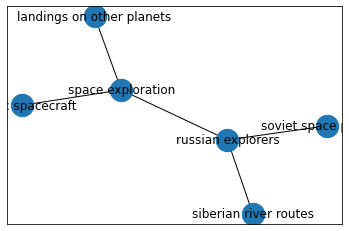

In [6]:
pos = nx.drawing.spring_layout(G)
nodelist = [
    'space exploration',
    'landings on other planets', 
    'robotic spacecraft', 
    'russian explorers',
    'siberian river routes',
    'soviet space program']
G_sub = nx.subgraph(G, nodelist)
nx.draw_networkx(G_sub, node_size=500, arrows=True)

## Random Walk
Random Walk is a technique to extract sequences from a graph. We can use these sequences to train a skip-gram model to learn node embeddings.

In [7]:
def get_randomwalk(node, path_length): 
    random_walk = [node]
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In the example below the length to traverse is specified as 5 and the start node is 'private spaceflight'.

In [8]:
get_randomwalk('private spaceflight', 5)


['private spaceflight',
 'armadillo aerospace',
 'commercial spaceflight federation',
 'newspace',
 'colonization of mars']

Capture the random walks for all the nodes in dataset for path length equals 10.

In [9]:
all_nodes = list(G.nodes())

random_walks = []
for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))
        
# count of sequences
len(random_walks)

100%|██████████| 2088/2088 [00:00<00:00, 9846.98it/s] 


10440

In the next step, generated sequences can be used as inputs to a skip-gram model.

## DeepWalk

In [10]:
from gensim.models import Word2Vec

In [11]:
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(975520, 1003540)

Every node in the graph is represented by a fixed length (100) vector.

## Similarity measurements

Return the most similar pages to 'russian explorers'.

In [12]:
model.wv.similar_by_word('russian explorers')

[('zapadnoye lake', 0.9330801963806152),
 ('operation sandblast', 0.9303088784217834),
 ('arctic and antarctic research institute', 0.9233442544937134),
 ('1966 soviet submarine global circumnavigation', 0.9228636622428894),
 ('russian geographical society', 0.9196107983589172),
 ('soviet antarctic expedition', 0.918620765209198),
 ('canadian canoe routes (early)', 0.9185143113136292),
 ('operation sea orbit', 0.9147406220436096),
 ('siberian route', 0.9129266142845154),
 ('soviet and russian manned drifting ice stations', 0.9123893976211548)]

All these pages are related to russian space exploration topics.

To see how well node embeddings capture the similarity between different nodes, handpick a few nodes from the graph and plot them on a 2-dimensional space.

In [13]:
terms = ['lunar escape systems','soviet moonshot', 'soyuz 7k-l1', 
         'moon landing','space food', 'food systems on space exploration missions', 
         'meal, ready-to-eat','space law', 'metalaw', 'moon treaty', 
         'legal aspects of computing','astronaut training', 'reduced-gravity aircraft', 
         'space adaptation syndrome', 'micro-g environment']
         

In [14]:
def plot_nodes(word_list):
    X = model.wv[word_list]
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    plt.figure(figsize=(12,9))
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))      
    plt.show()

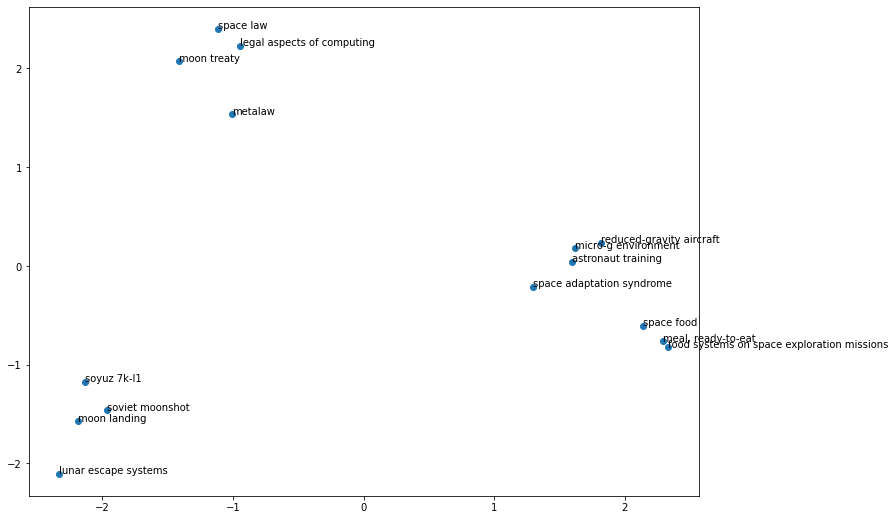

In [15]:
plot_nodes(terms)

Similar Wikipedia pages are grouped together, e.g. entries connected with law: 'space law', 'legal aspects of computing', 'metalaw'.